# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


## 4.1 Evaluation metrics: session overview

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [33]:
# Load the dataset
df = pd.read_csv('./Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Standardize column names: lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Identify all columns of type 'object' (i.e., strings/categorical)
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Normalize all string values: lowercase and replace spaces with underscores
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# Convert the 'totalcharges' column to numeric (some entries may be invalid)
# Invalid parsing results in NaN, which we then replace with 0
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

# Convert 'churn' column to binary: 1 if 'yes', else 0
df.churn = (df.churn == 'yes').astype(int)

# Split the dataset into train+val (80%) and test (20%)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Split train+val into actual train (60%) and validation (20%)
# (i.e., 0.25 of 0.8 = 0.2 → 60/20/20 split)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Reset row indices for consistency
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Extract target labels for each split (before deleting)
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

# Remove target column from features to isolate input features
del df_train['churn']
del df_val['churn']
del df_test['churn']


In [34]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)


model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

/media/nuopel/DATA/ProjectsAndTools/1_Projects/AI/P_machine-learning-zoomcamp/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


np.float64(0.8034066713981547)

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [35]:
(y_val == churn_decision).mean()


np.float64(0.8034066713981547)

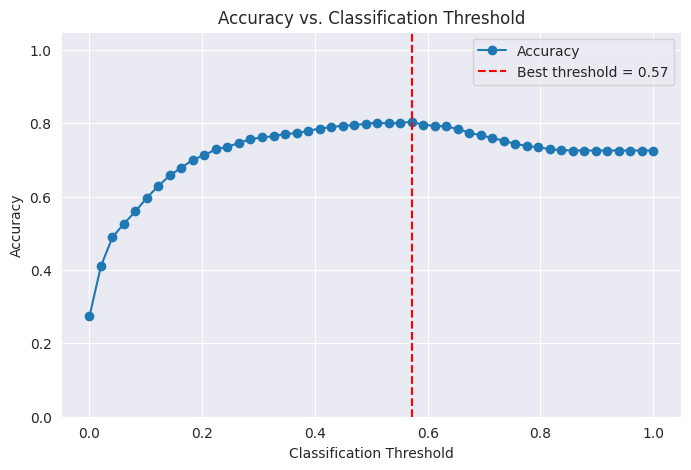

In [36]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Evaluate how accuracy varies with different classification thresholds

# Create a range of thresholds from 0.0 to 1.0 in 0.05 increments
thresholds = np.linspace(0, 1, 50)

# Store accuracy scores for each threshold
scores = []

# Compute accuracy at each threshold
for t in thresholds:
    preds = (y_pred >= t).astype(int)  # Binary prediction: churn if prob >= threshold
    score = accuracy_score(y_val, preds)
    scores.append(score)

# Find best threshold and corresponding accuracy
best_threshold = thresholds[np.argmax(scores)]
best_score = max(scores)

# Plot threshold vs. accuracy
plt.figure(figsize=(8, 5))
plt.plot(thresholds, scores, marker='o', label='Accuracy')
plt.axvline(best_threshold, linestyle='--', color='red', label=f'Best threshold = {best_threshold:.2f}')
plt.title("Accuracy vs. Classification Threshold")
plt.xlabel("Classification Threshold")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()


In [37]:
from collections import Counter
Counter(y_val)


Counter({np.int64(0): 1023, np.int64(1): 386})

So there is more non churning ( 73% ) than churning one (27%), which result in our model to not express accuracy due to class inbalance, the mmodel predict rather non churning and can be misleading.

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

In [38]:
# Define actual labels
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

# Define prediction threshold
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

# Count confusion matrix components
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

# Build confusion matrix
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

# Display confusion matrix and normalized version
(confusion_matrix / confusion_matrix.sum()).round(2)


array([[0.65, 0.07],
       [0.12, 0.15]])

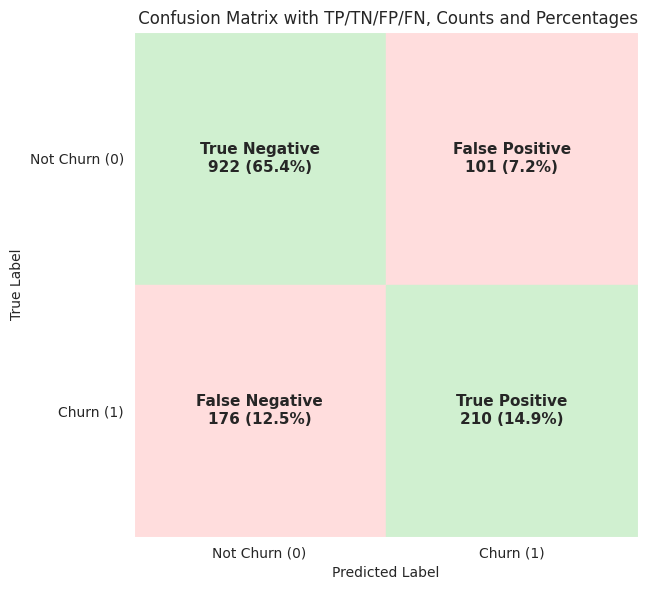

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Define the confusion matrix values
conf_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

# Calculate total and percentages
total = conf_matrix.sum()
conf_percent = conf_matrix / total * 100

# Labels for each cell
cell_names = np.array([
    ['True Negative', 'False Positive'],
    ['False Negative', 'True Positive']
])

# Generate combined annotation text without commas
annot = np.empty_like(conf_matrix, dtype=object)
for i in range(2):
    for j in range(2):
        label = cell_names[i, j]
        count = conf_matrix[i, j]
        percent = conf_percent[i, j]
        annot[i, j] = f"{label}\n{count} ({percent:.1f}%)"

# Define colors: green for correct predictions, red for mistakes
colors = np.array([
    ['#d0f0d0', '#fdd'],  # TN, FP
    ['#fdd', '#d0f0d0']   # FN, TP
])

# Set axis labels
x_labels = ['Not Churn (0)', 'Churn (1)']
y_labels = ['Not Churn (0)', 'Churn (1)']

# Plot setup
fig, ax = plt.subplots(figsize=(7, 6))

for i in range(2):
    for j in range(2):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=colors[i, j]))
        ax.text(j + 0.5, i + 0.5, annot[i, j],
                ha='center', va='center', fontsize=11, fontweight='bold', wrap=True)

# Axis ticks and labels
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(x_labels)
ax.set_yticks([0.5, 1.5])
ax.set_yticklabels(y_labels)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title(" Confusion Matrix with TP/TN/FP/FN, Counts and Percentages")

# Layout adjustments
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.grid(False)
plt.tight_layout()
plt.show()


## 4.4 Precision and Recall


In [40]:
# Compute precision and recall for  churning
p = tp / (tp + fp)  # Precision
r = tp / (tp + fn)  # Recall

# Print results
print(f"🔎 Precision: {p:.3f}")
print(f"📣 Recall:    {r:.3f}")


🔎 Precision: 0.675
📣 Recall:    0.544


In [41]:
# Compute precision and recall for non churning
p = tn / (tn + fn)  # Precision
r = tn / (tn + fp)  # Recall

# Print results
print(f"🔎 Precision: {p:.3f}")
print(f"📣 Recall:    {r:.3f}")
# note that this is not really usefull here because we are focus on the churning metric, but it shows here the imbalance noneway

🔎 Precision: 0.840
📣 Recall:    0.901


## 4.5 ROC Curves

### TPR and FRP

We're going to take a closer look at how the True Positive Ratio (TPR) and the False Positive Ratio (FPR) change as we adjust our decision thresholds. We'll do this by comparing three different models: our real model, a random one, and an ideal one. By contrasting these models, we can gain a clearer understanding of TPR and FPR. So, let's dive in and see how these ratios work across these different scenarios.


In [42]:
tpr = tp / (tp + fn)

fpr = fp / (fp + tn)
print(tpr,fpr)

0.5440414507772021 0.09872922776148582


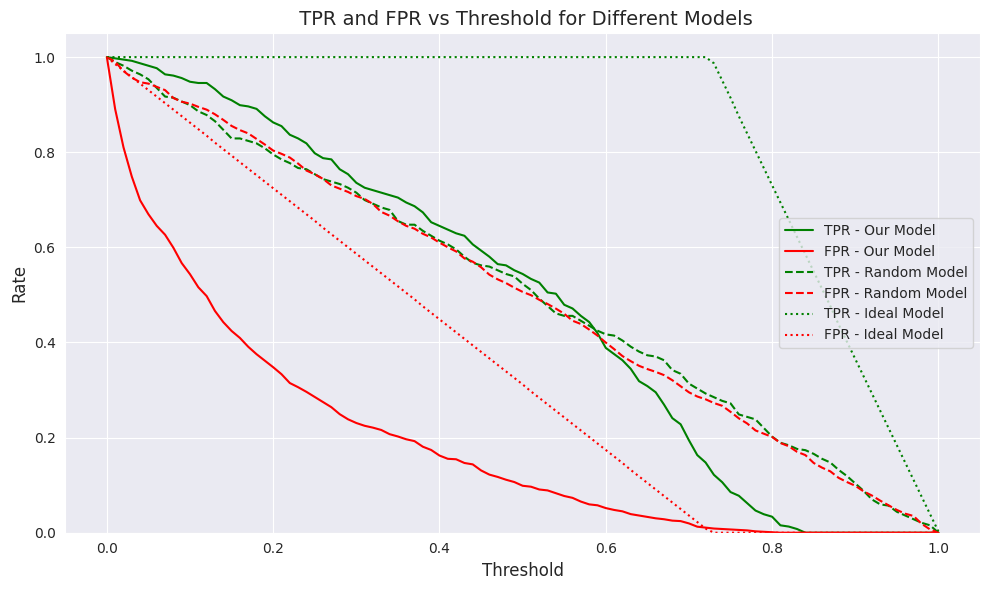

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ------------------------------
# Function to compute TPR and FPR across thresholds
# ------------------------------
def tpr_fpr_dataframe(y_true, y_scores):
    scores = []
    thresholds = np.linspace(0, 1, 101)  # 101 thresholds from 0.0 to 1.0

    for t in thresholds:
        # True class masks
        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        # Predicted class masks at threshold t
        predict_positive = (y_scores >= t)
        predict_negative = (y_scores < t)

        # Confusion matrix components
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    # Assemble results
    df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

    # Compute TPR (Recall) and FPR
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

# ------------------------------
# Generate TPR and FPR for three models
# ------------------------------

# 1. Our model
df_scores_ourmodel = tpr_fpr_dataframe(y_val, y_pred)

# 2. Random model (uniform predictions)
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
df_rand = tpr_fpr_dataframe(y_val, y_rand)

# 3. Ideal model (perfect separation: all 0s then all 1s)
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal_pred = np.linspace(0, 1, len(y_val))
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

# ------------------------------
# Plot TPR and FPR vs Threshold for all models
# ------------------------------
plt.figure(figsize=(10, 6))

# Our model
plt.plot(df_scores_ourmodel.threshold, df_scores_ourmodel.tpr,
         label='TPR - Our Model', color='green', linestyle='-')
plt.plot(df_scores_ourmodel.threshold, df_scores_ourmodel.fpr,
         label='FPR - Our Model', color='red', linestyle='-')

# Random model
plt.plot(df_rand.threshold, df_rand.tpr,
         label='TPR - Random Model', color='green', linestyle='--')
plt.plot(df_rand.threshold, df_rand.fpr,
         label='FPR - Random Model', color='red', linestyle='--')

# Ideal model
plt.plot(df_ideal.threshold, df_ideal.tpr,
         label='TPR - Ideal Model', color='green', linestyle=':')
plt.plot(df_ideal.threshold, df_ideal.fpr,
         label='FPR - Ideal Model', color='red', linestyle=':')

# ------------------------------
# Labels, legend, grid
# ------------------------------
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Rate", fontsize=12)
plt.title(" TPR and FPR vs Threshold for Different Models", fontsize=14)
plt.legend(loc="center right")
plt.grid(True)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


## 📈 Behavior of TPR and FPR vs. Threshold

### ✅ Our Model (Trained Logistic Regression)

At **threshold \$t = 0.0\$**, the model classifies **every customer as a churner**, because all predicted probabilities satisfy \$P(Y = 1 | \mathbf{x}\_i) \geq 0\$.

* **TPR = 100%**: All actual churners are correctly predicted as churners → no false negatives.
* **FPR = 100%**: All actual non-churners are incorrectly predicted as churners → no true negatives.

This extreme setting maximizes recall (TPR) but at the cost of maximum false alarms (FPR).

---

As the **threshold increases**:

* **FPR drops quickly**: The model begins to correctly classify more non-churners, reducing false positives.
* **TPR drops more slowly**: The model still identifies many churners correctly, maintaining good recall for a while.

👉 **Ideal behavior**:
A well-performing model shows a **steep drop in FPR** with a **slow decline in TPR**, meaning it retains the ability to detect churners while reducing false alarms.

This indicates **good discriminative power** — the model is able to separate churners from non-churners effectively by assigning higher probabilities to churners.

---

### 🎲 Random Model (Uniform Predictions)

In the **random model**, predicted probabilities are sampled uniformly in $\[0, 1]\$, independent of the actual labels.

At **threshold \$t = 0.0\$**:

* **TPR = 100%** and **FPR = 100%**: All customers are classified as churners.

As the **threshold increases**:

* Both **TPR** and **FPR** decline at a **similar pace**. This reflects the fact that the model has **no discriminative power** — it cannot distinguish between churners and non-churners.

By **threshold \$t = 1.0\$**:

* **TPR = 0%** and **FPR = 0%**: No customers are predicted as churners; all are classified as non-churners.

👉 In essence, this model is **equivalent to random guessing**, and the TPR/FPR plot forms a roughly **diagonal line** — an expected behavior for chance-level predictions.

---

### 🧠 Key Takeaway

* A **good model** separates TPR and FPR curves — keeping TPR high while driving FPR low across a range of thresholds.
* A **random model** shows both TPR and FPR decreasing in tandem, offering no predictive value.
* **Threshold tuning** can help you trade off between precision and recall depending on business objectives (e.g., aggressive churn prevention vs. cost control).


To create an ROC curve, instead of plotting FPR and TPR against different threshold values, we plot them against each other
* **Top-left corner (0, 1)** is the **ideal point**:
  → **0% FPR** (no false alarms)
  → **100% TPR** (all positives found)
  This represents a perfect classifier.

* The **diagonal line** (\$y = x\$) shows the performance of a **random classifier** — no real separation between classes.
  If your curve is **below** this line, your model is **worse than random** (e.g., it may be systematically inverted).

* The **closer your ROC curve hugs the top-left corner**, the better the classifier is at separating positives from negatives.



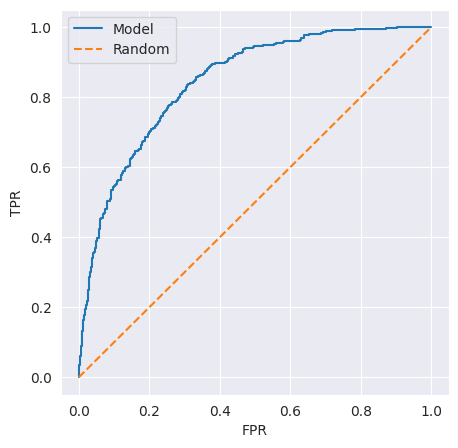

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6  ROC AUC

## 📐 ROC AUC – Intuition and Empirical Meaning

### ✅ What Is AUC?

AUC (Area Under the Curve) of the ROC curve tells us:

> **What is the probability that a randomly chosen positive instance gets a higher predicted score than a randomly chosen negative one?**

This gives a **ranking quality** of the classifier.

---

### 🧠 Example Interpretation:

Suppose you randomly pick:

* One customer who actually **churned** (positive)
* One who did **not churn** (negative)

Then:

* If the model gives the **churned** customer a higher score, that’s a **correct ranking**.
* The **AUC** is simply the fraction of such correct rankings across **many random pairs**.

---
### 📊 Summary Table

| Metric                     | Meaning                                                             |
| -------------------------- | ------------------------------------------------------------------- |
| `roc_auc_score`            | Area under ROC curve (TPR vs FPR)                                   |
| `auc(fpr, tpr)`            | Same as above, computed explicitly                                  |
| Empirical AUC via sampling | P(score(churned) > score(not churned)) using random pair comparison |

---

### ✅ Optional: Interpretation Sentence

> "An AUC of 0.87 means that in 87% of random positive–negative customer pairs, the model gives a higher score to the churned customer. This reflects a strong ability to **rank** churn risk correctly, even if not all predictions are perfect."
>


#### 1. `roc_auc_score(y_true, y_scores)`

* **Direct method**, built-in to `sklearn.metrics`
* Works directly from labels and prediction scores.
* Internally:

  * Sorts scores
  * Computes TPR and FPR at all thresholds
  * Integrates the resulting curve using the **trapezoidal rule**.
* Highly optimized and preferred for standard use.

#### 2. `auc(fpr, tpr)`

* Just applies the **trapezoidal rule** over the arrays `fpr` and `tpr`.
* You must supply the `fpr` and `tpr` arrays explicitly (e.g., from `roc_curve()`).

---


In [45]:

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

# --- Compute ROC and AUC ---
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# AUC via trapezoid integration
auc_trapezoid = auc(fpr, tpr)
print(f"AUC (from trapezoid): {auc_trapezoid:.3f}")

# AUC directly from ground truth and predicted scores
auc_direct = roc_auc_score(y_val, y_pred)
print(f"AUC (from roc_auc_score): {auc_direct:.3f}")

# Compare with ideal model
auc_ideal = auc(df_ideal.fpr, df_ideal.tpr)
print(f"AUC (ideal model): {auc_ideal:.3f}")


AUC (from trapezoid): 0.844
AUC (from roc_auc_score): 0.844
AUC (ideal model): 1.000


In [46]:

### 🎲 Empirical Simulation of AUC Meaning

# Separate positive and negative prediction scores
pos = y_pred[y_val == 1]  # churned
neg = y_pred[y_val == 0]  # not churned

# Simulate comparisons between random positive/negative pairs
n = 50_000
np.random.seed(1)

# Randomly select n indices from pos and neg
pos_sample = np.random.choice(pos, size=n, replace=True)
neg_sample = np.random.choice(neg, size=n, replace=True)

# Compare whether positive score > negative score
successes = (pos_sample > neg_sample).mean()
print(f"Empirical AUC (P[pos > neg]): {successes:.3f}")
#This last number should be **very close to the AUC** computed using `roc_auc_score`.


Empirical AUC (P[pos > neg]): 0.846


## 4.7 Cross validation

**k-Fold Cross-Validation**

Cross-validation is a technique where we divide the dataset, $\mathbf{D}$, into $k$ parts of equal size, which we call folds (e.g., $\mathbf{D}_1,\mathbf{D}_2, \cdots, \mathbf{D}_k$). Each fold, $\mathbf{D}_i$, is used as a testing set one time, with the rest serving as the training set.

To illustrate, consider we have a dataset and we choose $k=3$. The dataset is divided into 3 subsets or folds. In each iteration, we use one fold as the test set and the remaining folds as the training set, as show below:


So in each iteration, the model is trained on the training set and its performance is evaluated on the testing set, $\mathbf{D}_i$, to obtain the $i^{th}$ estimate, $\theta_i$.

From there, we can estimate the average performance measure as:

$$\hat{\mu}_{\theta} = \mathbf{E}[\theta] = \frac{1}{k}\sum_{i=1}^{k}\theta_i$$

We can also calculate the variance of the performance measure as:

$$\hat{\sigma}_{\theta}^2 = \frac{1}{k}\sum_{i=1}^{k}(\theta_i -\hat{\mu}_{\theta})^2$$

The process starts by randomly shuffling the dataset, $\mathbf{D}$, then split it into $k$ equal parts. In each round of validation, one fold, $\mathbf{D}_i$, serves as the testing set, and the model's performance, $\theta_i$, is assessed. The process is repeated multiple times with different shuffles of the data to ensure the results are reliable.

Typically, we choose $k$ as either 5 or 10.

The Python code for implementing this process is as follows:

In [64]:
def train(df, y):
    df_dict = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    dv.fit(df_dict)

    x_train = dv.transform(df_dict)

    model = LogisticRegression(solver='liblinear')
    model.fit(x_train, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

Here we used K-fold cross-validation with $K =10$. Thus, when we run it, at the end we
get 10 different numbers — 10 AUC scores evaluated on 10 different validation folds. We can think of it as a distribution of AUC scores for our model, making possible to get some statistic like mean and variance.

In [48]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

aucs = []

# for each fold, split the dataset into training and validation datasets
for train_idx, val_idx in kfold.split(df_full_train):

    # create training dataset using indices provided by k-fold object
    df_train = df_full_train.iloc[train_idx]
    y_train = df_train.churn.values

    df_val = df_full_train.iloc[val_idx]
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    # compute the AUC score and store it in the list
    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)


# print AUC for each fold
print('AUCs',np.array(aucs).round(3))

# print mean and standard deviation of AUCs across all folds
print('AUC stats = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

AUCs [0.849 0.841 0.859 0.833 0.824 0.841 0.844 0.824 0.845 0.861]
AUC stats = 0.842 ± 0.012


**Tuning the parameter `C`**

In logistic regression, a component known as the regularization term is incorporated into the cost function. This term operates by introducing a penalty to the cost function, analogous to the L2 regularization ridge() for linear regression. The penalty term helps prevent the model from overfitting by limiting the magnitude of the model parameters.

The strength of the regularization is controlled by the C parameter. A smaller C means stronger regularization, leading to smaller model parameters, whereas a larger C corresponds to weaker regularization, allowing the model parameters to take larger values.

Thus, by adjusting C, we can control the balance between keeping the model simple to avoid overfitting and allowing it to fit the training data as closely as possible.

In [73]:
def train_regul(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X =dv.fit_transform(cat)


    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def train_regul_scaling(df, y, C=1.0):
    df_copy = df.copy()
    # print("🔎 Original numerical values (first 5 rows):")
    # print(df_copy[numerical].head())
    # 1. Scale only numerical columns
    scaler = StandardScaler()
    # df_copy[numerical] = scaler.fit_transform(df_copy[numerical])
    # degrade the performance but i dont get why

    # Optionally convert back to DataFrame to preserve column names
    df_copy[numerical]  = pd.DataFrame(df_copy[numerical] , columns=numerical, index=df.index)

    # 2. Convert to dict
    cat = df_copy[categorical + numerical].to_dict(orient='records')

    # 3. DictVectorizer
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(cat)
    # 4. Train model
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

nfolds = 5
kfold = KFold(n_splits = nfolds, shuffle=True, random_state=1)

for C in [0.00001, 0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train_regul_scaling(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=1e-05, auc = 0.778 ± 0.017
C=0.001, auc = 0.825 ± 0.013
C=0.01, auc = 0.840 ± 0.009
C=0.1, auc = 0.841 ± 0.008
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


In [62]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np

def train_regul_scaling(df, y, C=1.0):
    df_copy = df.copy()

    # 1. Fit and apply scaler to numerical columns
    scaler = StandardScaler()
    X_num = scaler.fit_transform(df_copy[numerical].values)

    # 2. Fit and apply OneHotEncoder to categorical columns
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_cat = ohe.fit_transform(df_copy[categorical].values)

    # 3. Concatenate
    X = np.column_stack([X_num, X_cat])

    # 4. Train model
    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return scaler, ohe, model
def predict(df, scaler, ohe, model):
    X_num = scaler.transform(df[numerical].values)
    X_cat = ohe.transform(df[categorical].values)
    X = np.column_stack([X_num, X_cat])
    return model.predict_proba(X)[:, 1]
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [1e-5, 0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        scaler, ohe, model = train_regul_scaling(df_train, y_train, C=C)
        y_pred = predict(df_val, scaler, ohe, model)

        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print(f'C={C}, auc = {np.mean(aucs):.3f} ± {np.std(aucs):.3f}')
# Apply on test set
X_test_num = scaler.transform(df_test[numerical].values)
X_test_cat = ohe.transform(df_test[categorical].values)
X_test = np.column_stack([X_test_num, X_test_cat])

y_pred = model.predict_proba(X_test)[:, 1]
churn_dec = (y_pred > 0.5).astype(int)
accuracy = (y_test == churn_dec).mean()
print('Test accuracy:', accuracy)


C=1e-05, auc = 0.821 ± 0.011
C=0.001, auc = 0.836 ± 0.010
C=0.01, auc = 0.839 ± 0.008
C=0.1, auc = 0.841 ± 0.007
C=0.5, auc = 0.842 ± 0.007
C=1, auc = 0.842 ± 0.007
C=10, auc = 0.842 ± 0.007
Test accuracy: 0.8133427963094393


b| `C` Value | AUC: $\mu \pm  \sigma$  |
| --------- | ---------- |
| 0.001     | 0.825 ± 0.013 |
| 0.01      | 0.839 ± 0.009 |
| 0.1       | 0.841 ± 0.007 |
| 0.5       | 0.841 ± 0.007 |
| 1         | 0.841 ± 0.007 |
| 10        | 0.841 ± 0.007 |



We can observe that beyond $C=0.1$, the average AUC remains consistent and no longer increases. This indicates that a C value of $0.1$ is sufficient to maximize the model's predictive power.

However, when comparing the models using $C=0.5$ and $C=0.1$, the model with $C=0.5$ has a smaller standard deviation, indicating a more stable model performance across different folds. Given this, we would favor C=0.5 as it provides a more reliable model prediction.

Now for the last step, we train the model on the entire train and validation
datasets and apply it to the test dataset to verify it indeed works well for $C=0.5$

In [50]:
y_train = df_full_train.churn.values

dv, model = train_regul(df_full_train, y_train, C=0.5)
y_pred = predict(df_test, dv, model)

auc_05 = roc_auc_score(y_test, y_pred)
print('AUC for c = 0.5', auc_05.__round__(3))

AUC for c = 0.5 0.858


The AUC score on the test set is $0.858$, which, while it is higher than the validation score of $0.841 \pm 0.007$, is not drastically different. The difference between the test score and the validation score is slightly larger than the standard deviation from the cross-validation process, but it's still relatively close. This means that our model's performance on the test set is better than we estimated from cross-validation, but the difference is not so large that we would worry about overfitting to the training data. It shows that our model generalizes well to unseen data.

Note:
We did not use OneHotEncoder to scale the numerical data

## 4.9 Explore more
### Extra 1:Check the precision and recall of the dummy classifier that always predict "FALSE"

In [51]:
# Assume dummy prediction: always predict 0
y_dummy = np.zeros_like(y_val)

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_val, y_dummy, pos_label=1))
print(recall_score(y_val, y_dummy, pos_label=1))

0.0
0.0


/media/nuopel/DATA/ProjectsAndTools/1_Projects/AI/P_machine-learning-zoomcamp/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Dummy classifier that always predicts **"non-churn" (False)**:

| Metric        | Value | Why?                                                                            |
| ------------- | ----- | ------------------------------------------------------------------------------- |
| **Accuracy**  | \~73% | Because \~73% of customers actually don't churn, and the model gets them right. |
| **Precision** | 0%    | It **never predicts churn**, so there are **no true positives**.                |
| **Recall**    | 0%    | It **misses all churners**. Not a single one is predicted.                      |


* This "model" looks **good** by accuracy, but it’s **useless** in practice.
* It highlights **why accuracy is misleading** when:

> A classifier that always predicts “no churn” may achieve 73% accuracy, but has **0% precision** and **0% recall** for churners — making it **completely ineffective** for detecting the very outcome we care about.



### F1 score
F1 score is **single number** that balances precision and recall. Especially useful when classes are imbalanced.

---

* The F1 score penalizes models that perform **very well on one metric but poorly on the other**.
* It’s **low** if either precision or recall is low.
* Useful when **false negatives** and **false positives** both matter.

---

### ✅ Takeaway

> The **F1 score** gives a better overall measure of a model’s performance on the positive class (churners), especially when class imbalance makes accuracy unreliable.

Would you like to also see how to compute it using `sklearn.metrics.f1_score` for verification?

In [52]:
# True Positive, False Positive, False Negative (already computed)
# tp, fp, fn
from sklearn.metrics import f1_score

# Precision and Recall for churners
precision = tp / (tp + fp)
recall = tp / (tp + fn)

# F1 score
f1 = 2 * precision * recall / (precision + recall)
f1bis = f1_score(y_val, churn_decision, average='binary')
# Print results
print(f"🔎 Precision: {precision:.3f}")
print(f"📣 Recall:    {recall:.3f}")
print(f"🎯 F1 Score:  {f1:.3f}")
print(f"🎯 F1 Score:  {f1bis:.3f}")


ValueError: Found input variables with inconsistent numbers of samples: [1126, 1409]

## Extra :  PR curve

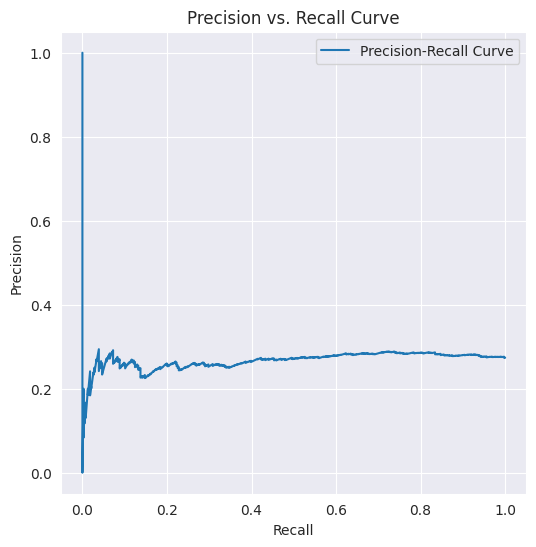

📐 Area under Precision-Recall curve (PR AUC): 0.267


np.float64(0.2739531582682754)

In [114]:
from sklearn.metrics import precision_recall_curve

# y_val: true labels
# y_pred: probability scores (not binary!)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs. Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

from sklearn.metrics import auc

pr_auc = auc(recall, precision)
print(f"📐 Area under Precision-Recall curve (PR AUC): {pr_auc:.3f}")
y_val.mean()


## 📉 Precision-Recall Curve Analysis

### 🔍 Behavior at Extremes

* At **threshold ≈ 0**:

  * **Recall = 100%** (all churners predicted)
  * **Precision is very low** (many false positives)

* As **threshold increases**:

  * **Recall decreases**
  * **Precision increases**, but remains mostly **below 0.3**

---

### 🤔 Why This Happens

* **Class imbalance** — only \~27% of customers actually churn
* The model **overpredicts churn**:

  * It catches some real churners (TP)
  * But also incorrectly labels many non-churners (FP)
* Precision drops quickly as recall increases → model lacks **confidence**

---

### 📐 PR AUC = 0.267

* Evaluates performance **only on the positive class** (churners)
* **Low score** → the model struggles to **identify churners precisely**
* Even if **ROC AUC ≈ 0.84** suggests good ranking, PR AUC shows **real limitations**

---

### 🎯 Key Takeaways

* **PR curve** focuses on the **quality of positive predictions**
* Especially useful when dealing with **imbalanced datasets**

---

### 📏 Rule of Thumb

| PR AUC vs. Churn Rate | Interpretation                        |
| --------------------- | ------------------------------------- |
| PR AUC < churn rate   | Worse than random — model is confused |
| PR AUC ≈ churn rate   | Like a random model                   |
| PR AUC > churn rate   | Model has real predictive power       |

---

### 🧠 Why This Makes Sense

* In imbalanced settings:

  * A **random classifier** achieves **PR AUC ≈ class proportion**
  * A **good model** boosts precision **while keeping recall decent**

0

C=1e-05, auc = 0.821 ± 0.011
C=0.001, auc = 0.836 ± 0.010
C=0.01, auc = 0.839 ± 0.008
C=0.1, auc = 0.841 ± 0.007
C=0.5, auc = 0.842 ± 0.007
C=1, auc = 0.842 ± 0.007
C=10, auc = 0.842 ± 0.007
Test accuracy: 0.8133427963094393
